# Sent-LDA



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
with open(r"data&software/data/groundTruth.dat") as datFile:
    topic_data = pd.DataFrame([data.split("\t") for data in datFile])
    
topic_data.columns = ["label", "doc_id", "sentence_id", "topic", "text"]
topic_data.label = topic_data.label.astype(int)
topic_data.topic = topic_data.topic.astype(int)
topic_data.sort_values(by = ["label"])
topic_data

,label,doc_id,sentence_id,topic,text
0,6,3,18,4,OUR OPERATIONS ARE VULNERABLE TO NATURAL DISAS...
1,6,24,11,4,Our reputation and financial results could be ...
2,20,26,18,10,The markets for Alcan's products are highly co...
3,10,67,25,1,If we fail to secure or protect our intellectu...
4,8,67,37,7,We may experience a decrease in market demand ...
...,...,...,...,...,...
1837,26,13457,20,27,We may not be able to meet the cash flow requi...
1838,5,13462,10,17,Our failure to comply with environmental regul...
1839,15,13467,7,0,Our businesses are dependent on the continuing...
1840,10,13471,25,1,We might be subject to claims of infringement ...


In [3]:
with open('bq_2018.json') as json_file:
    data = pd.DataFrame(json.loads(file) for file in json_file)

In [4]:
data

,f0_,CIK,coDescription
0,2018-07-28 04:00:00 UTC,1576942,Item 1A. Risk Factors. Risks Related to Our Bu...
1,2018-02-15 05:00:00 UTC,1496264,ITEM 1A. Risk Factors Forward-looking S...
2,2018-01-01 05:00:00 UTC,1592379,Item 1A. Risk FactorsAn investment in our comm...
3,2018-01-01 05:00:00 UTC,1116942,ITEM 1A.RISK FACTORS. An investment in our co...
4,2018-01-05 05:00:00 UTC,1702780,Item 1A. Risk FactorsRisk Factors Relating ...
...,...,...,...
742,2018-01-31 05:00:00 UTC,1358654,ITEM 1A: RISK FACTORS IN ADDITION TO THE FACT...
743,2018-01-31 05:00:00 UTC,1546652,Item1A. Risk Factors Beforemaking an investmen...
744,2018-01-31 05:00:00 UTC,1438901,Item 1A. Risk Factors.Business RiskAn investm...
745,2018-01-31 05:00:00 UTC,1676047,Item 1A. Risk Factors Ourbusiness is subject t...


In [5]:
ticker = pd.read_csv('cik_ticker.csv')
ticker

,CIK,Ticker,Name,Exchange,SIC,Business,Incorporated,IRS
0,1090872,A,Agilent Technologies Inc,NYSE,3825.0,CA,DE,770518772.0
1,4281,AA,Alcoa Inc,NYSE,3350.0,PA,PA,250317820.0
2,1332552,AAACU,Asia Automotive Acquisition Corp,NaN,6770.0,DE,DE,203022522.0
3,1287145,AABB,Asia Broadband Inc,OTC,8200.0,GA,NV,721569126.0
4,1024015,AABC,Access Anytime Bancorp Inc,NaN,6035.0,NM,DE,850444597.0
...,...,...,...,...,...,...,...,...
13732,827056,ZVXI,Zevex International Inc,NaN,3845.0,UT,NV,870462807.0
13733,846475,ZYNX,Zynex Inc,NaN,3845.0,CO,NV,870403828.0
13734,1406796,ZYTC,Zyto Corp,NaN,3841.0,UT,NaN,205534033.0
13735,748015,ZZ,Sealy Corp,NYSE,2510.0,WA,DE,363284147.0


In [6]:
data['CIK'] = data['CIK'].astype(int)

In [7]:
df = pd.merge(data, ticker[['CIK', 'Name', 'SIC']], left_on = data.CIK, right_on = ticker.CIK)

In [8]:
df = df.dropna().reset_index().drop(columns = ['index', 'CIK_x', 'CIK_y'])
df.columns = ['CIK', 'Reporting_Date','coDescription','Name', 'SIC']
df.SIC = df.SIC.astype(int)

In [9]:
#strip any left over html code
def clean_data_fn(insrt_data):
    clean_data = []
    for idx, ele in insrt_data.iterrows():
        clean_txt = re.compile('<.*?>')
        desc = re.sub(clean_txt,'',ele["coDescription"]).replace(u'\xa0', u' ').replace("   ", "").replace("'", "").replace('"','')
        if re.search('<', desc):
            pos = re.search('<', desc).start()
        desc = desc[:pos].lower()
        if (desc.find("risk factors") >= 25): # didnt find it in the first 25 characters then look for next
            desc = desc[8 : ( desc.rfind("<") )] # remove the "Item 1." stuff only
        else: # found "business", remove everything before it
            desc =  desc[( desc.find("risk factors") + 12 ) : ( desc.rfind("<") ) ]
            # remove leading white space and periods
            #desc = re.sub(r"^\.", "", desc).strip()            
        new_data = ele.copy()
        new_data["coDescription"] = desc
            # remove any filings with a description less than 250 characters (not enough information for us)
        clean_data.append(new_data)
                
    return(pd.DataFrame(clean_data))

df_clean = clean_data_fn(df)
df_clean.head()

,CIK,Reporting_Date,coDescription,Name,SIC
0,1116942,2018-01-01 05:00:00 UTC,. an investment in our common stock involves ...,TTM Technologies Inc,3672
1,723125,2018-08-30 04:00:00 UTC,in addition to the factors discussed elsewhere...,Micron Technology Inc,3674
2,886137,2018-03-03 05:00:00 UTC,forward-looking statementsforward-looking stat...,Finish Line Inc,5661
3,1000228,2018-02-21 05:00:00 UTC,the risks described below could have a materi...,Henry Schein Inc,5047
4,1000228,2018-12-29 05:00:00 UTC,the risks described below could have a materi...,Henry Schein Inc,5047


In [10]:
#lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokenize(sentence)]
    return " ".join(lemmatized_output)

lemma_desc = df_clean["coDescription"].apply(lemmatize_sentence)
df_clean["coDescription_lemmatized"] = lemma_desc

# remove all numbers so they don't show up as dimensions
def remove_nums(x):
    text = x
    text = re.sub(r'\d+', '', text)
    return text

# remove stopwords and punctuation
def remove_stopwords(x):
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(x)

    filtered_sentence = ' '.join([w for w in word_tokens if not w in stop_words and w.isalnum()])

    return(filtered_sentence)

rm_num_stopwords = df_clean["coDescription_lemmatized"].apply(remove_nums).apply(remove_stopwords)
df_clean["coDescription_stopwords"] = rm_num_stopwords

df_clean.head()

,CIK,Reporting_Date,coDescription,Name,SIC,coDescription_lemmatized,coDescription_stopwords
0,1116942,2018-01-01 05:00:00 UTC,. an investment in our common stock involves ...,TTM Technologies Inc,3672,. an investment in our common stock involves a...,investment common stock involves high degree r...
1,723125,2018-08-30 04:00:00 UTC,in addition to the factors discussed elsewhere...,Micron Technology Inc,3674,in addition to the factor discussed elsewhere ...,addition factor discussed elsewhere form follo...
2,886137,2018-03-03 05:00:00 UTC,forward-looking statementsforward-looking stat...,Finish Line Inc,5661,forward-looking statementsforward-looking stat...,statement term defined private security litiga...
3,1000228,2018-02-21 05:00:00 UTC,the risks described below could have a materi...,Henry Schein Inc,5047,the risk described below could have a material...,risk described could material adverse effect b...
4,1000228,2018-12-29 05:00:00 UTC,the risks described below could have a materi...,Henry Schein Inc,5047,the risk described below could have a material...,risk described could material adverse effect b...


In [11]:
# split the document to sentence
list_sent = df_clean.coDescription[0].split('.')

### LDA

In [12]:
data = df_clean.loc[:,"coDescription_stopwords"].to_list()
len(data)

497

In [19]:
def get_topics(model, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = tf_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [14]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel

dictionary = Dictionary(doc.split() for doc in data)
 # filter out too in/frequent tokens
dictionary.filter_extremes(no_below=0.01, no_above=0.85, keep_n = 5000)

corpus = [dictionary.doc2bow(doc.split()) for doc in data]
# create list of topic number we want to try 
topic_nums = list(np.arange(3, 40,3))

coherence_scores = []
for num in topic_nums:
    lda = LdaModel(corpus=corpus,
    num_topics=num,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0.01,
    random_state=0)
    
    
    cm = CoherenceModel(
    model=lda,
    texts=[doc.split() for doc in data],
    dictionary=dictionary,
    coherence="c_v")

    coherence_scores.append(round(cm.get_coherence(),5))

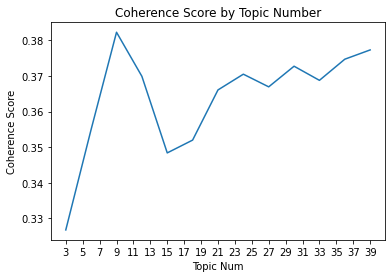

In [15]:
import matplotlib.pyplot as plt
scores = list(zip(topic_nums, coherence_scores))
plt.plot(topic_nums, coherence_scores)
plt.xticks(np.arange(3, 40,2))
plt.ylabel('Coherence Score')
plt.xlabel('Topic Num')
plt.title("Coherence Score by Topic Number")
plt.show()

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names()
lda = LatentDirichletAllocation(n_components=25, random_state=0).fit(tf)

/Users/lulu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
get_topics(lda,25)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20,Topic # 21,Topic # 22,Topic # 23,Topic # 24,Topic # 25
0,debt,home,fiscal,note,software,policy,fiscal,loan,gas,trust,...,consumer,member,restaurant,million,tax,merger,share,store,client,candidate
1,indebtedness,credit,tax,share,data,insurance,million,bank,oil,venture,...,brand,item,food,tax,manufacturing,mineral,director,merchandise,data,clinical
2,credit,construction,net,wa,offering,life,reporting,institution,natural,joint,...,tax,advertising,consumer,fiscal,supplier,project,stockholder,vendor,tax,patent
3,facility,financing,store,statement,intellectual,water,internal,credit,production,claim,...,foreign,restaurant,brand,income,acquisition,shareholder,rule,consumer,solution,approval
4,acquisition,claim,january,ended,license,reporting,september,program,reserve,court,...,retail,high,claim,net,foreign,transaction,trading,credit,claim,trial
5,note,facility,income,july,competitor,report,statement,real,energy,united,...,supplier,platform,lease,wa,supply,director,penny,inventory,acquisition,fda
6,obligation,debt,foreign,march,application,benefit,wa,estate,environmental,share,...,distribution,see,health,fair,facility,share,officer,retail,position,right
7,flow,insurance,share,tax,right,public,accounting,federal,water,independent,...,currency,wa,supply,share,intellectual,acquisition,investor,disruption,reputation,research
8,covenant,availability,consolidated,net,delay,internal,report,commercial,flow,fund,...,country,approximately,publicity,consolidated,trade,combination,right,data,access,third
9,financing,labor,wa,june,tax,receivable,income,income,commodity,unit,...,manufacturer,solution,federal,statement,component,financing,sell,distribution,legal,drug


### Assign Frequency of the topic to each sentence

In [30]:
n_components = 25
prob = pd.DataFrame(0, index = df.CIK, columns = range(n_components))

In [31]:
for j in range(len(df_clean)):
    LIST_sent = pd.Series(df_clean.coDescription[j].split('.')).apply(lemmatize_sentence).apply(remove_nums).apply(remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 0.25
    sent_df = sent_df[sent_df.max(axis = 1) > 0.25].reset_index(drop = True)

    for i in range(25):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)
    
#for i in 

In [32]:
prob

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CIK,,,,,,,,,,,,,,,,,,,,,
1116942,0.139860,0.027972,0.050699,0.017483,0.055944,0.026224,0.013986,0.006993,0.054196,0.008741,...,0.027972,0.017483,0.013986,0.045455,0.173077,0.043706,0.019231,0.022727,0.034965,0.038462
723125,0.086154,0.021538,0.040000,0.021538,0.061538,0.009231,0.015385,0.015385,0.021538,0.076923,...,0.040000,0.036923,0.006154,0.006154,0.252308,0.027692,0.036923,0.033846,0.036923,0.033846
886137,0.026549,0.026549,0.017699,0.026549,0.035398,0.004425,0.039823,0.008850,0.013274,0.013274,...,0.044248,0.026549,0.035398,0.026549,0.048673,0.172566,0.030973,0.221239,0.044248,0.008850
1000228,0.025090,0.010753,0.014337,0.003584,0.103943,0.021505,0.017921,0.014337,0.007168,0.010753,...,0.028674,0.017921,0.014337,0.000000,0.078853,0.014337,0.017921,0.021505,0.053763,0.028674
1000228,0.024561,0.010526,0.017544,0.003509,0.101754,0.028070,0.014035,0.003509,0.007018,0.014035,...,0.031579,0.014035,0.017544,0.007018,0.077193,0.014035,0.021053,0.017544,0.049123,0.017544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464165,0.021277,0.021277,0.010638,0.021277,0.042553,0.031915,0.000000,0.000000,0.005319,0.000000,...,0.010638,0.005319,0.005319,0.010638,0.026596,0.031915,0.196809,0.000000,0.031915,0.398936
914122,0.090909,0.045455,0.022727,0.045455,0.045455,0.015152,0.083333,0.007576,0.060606,0.007576,...,0.045455,0.015152,0.000000,0.060606,0.121212,0.037879,0.007576,0.037879,0.060606,0.007576
1172178,0.030303,0.053030,0.007576,0.037879,0.037879,0.022727,0.007576,0.000000,0.053030,0.030303,...,0.007576,0.030303,0.007576,0.000000,0.015152,0.083333,0.424242,0.007576,0.015152,0.007576


### Monthly Returns

In [24]:
returns_data = pd.read_csv('returns_2018_top5_SIC.csv', 
                      parse_dates = ['DATE'], 
                      usecols = ["trt1m", "CIK", "name", "DATE"])

In [25]:
# TAKE OUT THE DATA before 2019 and reset index
end_date = pd.to_datetime('2019-01-01')
returns = returns_data.loc[(returns_data['DATE'] < end_date)]
# drop the missing value
returns = returns.dropna()

In [26]:
group_returns = returns.groupby(['CIK', 'name', 'DATE'])
# calculate the percentage return
group_returns_pct = group_returns.agg({"trt1m": (lambda x:  x/100)})

In [27]:
r_selected = group_returns_pct.unstack()
# drop the first index
r_selected.columns = r_selected.columns.droplevel(0)

In [28]:
r_selected.index.get_level_values(0)

Int64Index([   1800,    3116,    3499,    7332,    7789,    8504,   10048,
              10254,   14272,   14846,
            ...
            1689796, 1689813, 1689923, 1701040, 1701732, 1702750, 1703644,
            1705696, 1708405, 1723128],
           dtype='int64', name='CIK', length=844)

In [33]:
# there are some rows containing more than one float number (array of multiple returns)
for i in range(len(r_selected)):
    if type(r_selected.iloc[i,1]) == np.ndarray:
        r_selected = r_selected.drop(index = r_selected.index[i])
# convert object to float
r_selected = r_selected.astype(float)
# drop missing values rows
r_selected = r_selected.dropna()

In [34]:
r_selected

,DATE,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
CIK,name,,,,,,,,,,,,,,,,,,,,,
1800,ABBOTT LABORATORIES,-0.008075,0.145001,-0.061006,0.006426,-0.065973,-0.029817,0.008931,0.094376,0.079243,-0.014862,...,-0.006796,-0.025200,0.058490,-0.008776,0.079193,0.019835,0.097546,-0.056434,0.074122,-0.023228
3116,AKORN INC,-0.047006,0.201685,-0.213555,0.012630,-0.121423,-0.113987,0.028746,-0.125057,0.089529,0.157136,...,0.104486,-0.228755,-0.031878,0.187545,0.116335,-0.152808,-0.172721,-0.486133,0.028486,-0.505831
3499,ALEXANDERS INC,0.117047,0.048970,0.011042,-0.024209,-0.084199,0.123429,-0.001941,0.000445,0.033916,-0.012101,...,0.043522,0.031792,-0.003432,-0.012568,-0.031754,-0.013631,-0.048846,-0.082406,0.000190,-0.018772
7332,SOUTHWESTERN ENERGY CO,-0.079737,0.158983,-0.045953,-0.005032,-0.249277,0.092397,-0.046696,-0.167283,-0.166482,0.087883,...,0.212885,-0.053118,0.153659,0.120507,-0.030189,0.093385,-0.090747,0.045010,-0.097378,-0.292531
7789,ASSOCIATED BANC-CORP,-0.082397,0.084548,0.072581,-0.012601,0.036243,0.131527,0.080963,0.024291,0.022530,-0.052427,...,0.006073,0.064386,0.049149,-0.010870,-0.010989,0.014815,-0.045872,-0.108462,0.006903,-0.145878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656936,MGM GROWTH PROPERTIES LLC,0.171444,0.016117,-0.069716,0.049068,0.009590,-0.088146,0.070729,0.020150,-0.015492,0.079367,...,0.027048,0.053881,0.061137,0.040768,-0.005253,0.014191,-0.026115,-0.040692,0.007070,-0.057301
1658566,"CENTENNIAL RESOURCE DEVELOPMENT, INC.",-0.023904,0.146939,0.115658,0.255981,-0.057143,0.225589,0.083516,-0.073529,0.029557,-0.030835,...,-0.038260,0.008174,-0.048649,0.026136,-0.005537,0.072940,0.133887,-0.123112,-0.189979,-0.289948
1667313,"ZEDGE, INC.",-0.386364,-0.093682,0.072115,-0.233184,-0.146199,0.236301,-0.132964,0.057508,0.048338,-0.115274,...,-0.030303,0.321875,-0.078014,-0.035897,-0.210106,-0.013468,-0.320819,-0.025126,0.829897,-0.310423


In [35]:
combined = pd.merge(df, r_selected, left_on = df.CIK, right_on = r_selected.index.get_level_values(0))

In [36]:
combined = combined.set_index(combined.CIK)

In [37]:
to_select = list(combined.CIK)

In [38]:
B_matrix = prob.T[to_select].T
B_matrix

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CIK,,,,,,,,,,,,,,,,,,,,,
849399,0.090343,0.012461,0.015576,0.009346,0.289720,0.037383,0.003115,0.000000,0.000000,0.006231,...,0.037383,0.037383,0.012461,0.018692,0.068536,0.021807,0.065421,0.037383,0.130841,0.024922
10048,0.031250,0.026786,0.022321,0.004464,0.040179,0.040179,0.040179,0.008929,0.357143,0.013393,...,0.008929,0.017857,0.013393,0.022321,0.035714,0.040179,0.040179,0.026786,0.008929,0.013393
67625,0.114754,0.045082,0.012295,0.012295,0.036885,0.036885,0.020492,0.069672,0.016393,0.008197,...,0.004098,0.012295,0.000000,0.012295,0.008197,0.057377,0.057377,0.016393,0.024590,0.004098
315131,0.079602,0.019900,0.004975,0.039801,0.009950,0.039801,0.024876,0.009950,0.442786,0.024876,...,0.009950,0.000000,0.000000,0.049751,0.009950,0.024876,0.044776,0.000000,0.034826,0.009950
1002517,0.090909,0.003788,0.026515,0.018939,0.178030,0.011364,0.049242,0.011364,0.007576,0.011364,...,0.045455,0.015152,0.003788,0.117424,0.045455,0.022727,0.087121,0.053030,0.075758,0.026515
1378590,0.053398,0.000000,0.004854,0.019417,0.281553,0.033981,0.043689,0.029126,0.004854,0.009709,...,0.024272,0.024272,0.024272,0.024272,0.043689,0.009709,0.126214,0.024272,0.092233,0.048544
1177648,0.007421,0.011132,0.009276,0.011132,0.053803,0.035250,0.020408,0.003711,0.001855,0.005566,...,0.022263,0.016698,0.000000,0.014842,0.029685,0.011132,0.061224,0.007421,0.029685,0.486085
14846,0.054201,0.002710,0.035230,0.081301,0.000000,0.002710,0.311653,0.051491,0.000000,0.048780,...,0.002710,0.040650,0.002710,0.184282,0.021680,0.002710,0.013550,0.010840,0.010840,0.000000
792130,0.018587,0.007435,0.007435,0.040892,0.252788,0.022305,0.055762,0.003717,0.007435,0.014870,...,0.048327,0.018587,0.003717,0.022305,0.044610,0.066914,0.104089,0.014870,0.089219,0.074349


In [39]:
r_t = combined.iloc[:,6:]

In [40]:
len(r_t.columns)

31

In [41]:
B_matrix

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CIK,,,,,,,,,,,,,,,,,,,,,
849399,0.090343,0.012461,0.015576,0.009346,0.289720,0.037383,0.003115,0.000000,0.000000,0.006231,...,0.037383,0.037383,0.012461,0.018692,0.068536,0.021807,0.065421,0.037383,0.130841,0.024922
10048,0.031250,0.026786,0.022321,0.004464,0.040179,0.040179,0.040179,0.008929,0.357143,0.013393,...,0.008929,0.017857,0.013393,0.022321,0.035714,0.040179,0.040179,0.026786,0.008929,0.013393
67625,0.114754,0.045082,0.012295,0.012295,0.036885,0.036885,0.020492,0.069672,0.016393,0.008197,...,0.004098,0.012295,0.000000,0.012295,0.008197,0.057377,0.057377,0.016393,0.024590,0.004098
315131,0.079602,0.019900,0.004975,0.039801,0.009950,0.039801,0.024876,0.009950,0.442786,0.024876,...,0.009950,0.000000,0.000000,0.049751,0.009950,0.024876,0.044776,0.000000,0.034826,0.009950
1002517,0.090909,0.003788,0.026515,0.018939,0.178030,0.011364,0.049242,0.011364,0.007576,0.011364,...,0.045455,0.015152,0.003788,0.117424,0.045455,0.022727,0.087121,0.053030,0.075758,0.026515
1378590,0.053398,0.000000,0.004854,0.019417,0.281553,0.033981,0.043689,0.029126,0.004854,0.009709,...,0.024272,0.024272,0.024272,0.024272,0.043689,0.009709,0.126214,0.024272,0.092233,0.048544
1177648,0.007421,0.011132,0.009276,0.011132,0.053803,0.035250,0.020408,0.003711,0.001855,0.005566,...,0.022263,0.016698,0.000000,0.014842,0.029685,0.011132,0.061224,0.007421,0.029685,0.486085
14846,0.054201,0.002710,0.035230,0.081301,0.000000,0.002710,0.311653,0.051491,0.000000,0.048780,...,0.002710,0.040650,0.002710,0.184282,0.021680,0.002710,0.013550,0.010840,0.010840,0.000000
792130,0.018587,0.007435,0.007435,0.040892,0.252788,0.022305,0.055762,0.003717,0.007435,0.014870,...,0.048327,0.018587,0.003717,0.022305,0.044610,0.066914,0.104089,0.014870,0.089219,0.074349


In [42]:
type(r_t[r_t.columns[0]])

pandas.core.series.Series

In [43]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
for i in range(len(r_t.columns)):
    date = r_t.columns[i]
    r_t_i = r_t[date] 
    reg = LinearRegression().fit(B_matrix, r_t_i)
    #print(reg.score(B_matrix, r_t_i))
    print(reg.coef_)
    #print(reg.get_params(deep=True))
    #LinearRegression().fit(B_matrix, r_t_i)
    #print(LinearRegression().fit(B_matrix, r_t_i))

[ -0.11945096  -7.2520943   -2.31772812  -5.3953806   -0.59610172
  -0.19770607  -3.27246053  12.87121737  -0.25000635  -8.85718677
  12.47585716   3.78959986  -1.10171677  -2.46553015  -2.16819163
  -0.36330733   3.43086828   6.70953127   3.5022691   -0.89260561
   3.63209949  -1.92182394 -13.79217425   4.6975492   -0.14552662]
[-2.14422445  6.56840573  7.04771475 -1.84179142 -0.7091477   1.68563332
 -0.50889239 -7.2292899  -0.74210296 -2.15777372  2.12636554 -4.44496487
 -0.34135309 -0.30406838 -0.19558781 -3.47267869 -0.28295288  5.8954451
  1.14418967 -2.07835029  2.81661942 -1.18568103 -0.10463049  1.02672944
 -0.56761291]
[ -2.28927545   9.46275603   5.47488924 -10.25056625  -2.65210585
  -0.39623004  -2.41137618   6.25504136  -1.17407235 -19.25754023
  12.38040492  -0.18942012  -2.33865447   2.73432501  -4.45057617
  -2.21773045   3.56530292  15.79887903   5.9381332   -5.38692413
   9.94351682  -3.43257771 -23.61265902   9.87395419  -1.3674943 ]
[ 0.02918252 -3.74190051 -3.47106

## Plotting

### Plotting on the wordsCount matrix

In [44]:
#pip install plotly

In [45]:
from sklearn.decomposition import PCA
import plotly.express as px

# Referenced from Richard's CSCD25 course
def visualize(vectors, index, category):
    pca = PCA(n_components=20)
    pca_embedding = pca.fit_transform(vectors)
    pca_embedding = pd.DataFrame(pca_embedding, index = index)
    
    pca_embedding['SIC'] = list(category)
    pca_embedding['SIC'] = pca_embedding['SIC'].astype('category')
    
    fig = px.scatter(pca_embedding, x =0 , y = 1, 
                     hover_data={"Name": pca_embedding.index}, 
                     color = 'SIC', width=1200, height=750)
    fig.show()
    
    return [pca, pca_embedding]

In [46]:
plot = visualize(wordsCount, wordsCount.index, df['SIC_desc'])

NameError: name 'wordsCount' is not defined

In [ ]:
fig = px.scatter_3d(plot[1], x =0 , y = 1, z = 2, hover_data={"name": plot[1].index}, color = 'SIC', width=1200, height=700)
fig.show()

### Plotting on the cosine_sim matrix

In [ ]:
plot_cos = visualize(cosine_sim, cosine_sim.index, df['SIC_desc'])

In [ ]:
fig = px.scatter_3d(plot_cos[1], x =0 , y = 1, z = 2, hover_data={"name": plot_cos[1].index}, color = 'SIC', width=1200, height=700)
fig.show()

### Plotting on the cosine_sim_pos_tag matrix

In [ ]:
plot_pos_tag = visualize(cosine_sim_pos_tag, cosine_sim_pos_tag.index, df['SIC_desc'])

In [ ]:
fig = px.scatter_3d(plot_pos_tag[1], x =0 , y = 1, z = 2, hover_data={"name": plot_pos_tag[1].index}, color = 'SIC', width=1200, height=700)
fig.show()

In [ ]:
#plot[0].explained_variance_ratio_

In [ ]:
#plt.plot(plot[0].explained_variance_ratio_.cumsum(), marker='o', linestyle='--')